<a id='Top'></a>
<center>
    <h1><u><b>Mall Customers Segmentation</b></u></h1>
<h3>Author: Robert Kwiatkowski</h3>
</center>

---

This project shows how to perform a mall customers segmentation using Machine Learning algorithms. This is the unsupervised clustering problem and three popular algorithms will be presented and compared: KMeans, Affinity Propagation and DBSCAN. There will be some further discussions about these algorithms alterations and their current state of developments/research. The main aim of this notebook is to cover the basics of clustering methods and touch some more advanced aspects as well.

The notebook is divided into six main sections. At the end of the notebook, you will find also references I used during the preparation of this notebook. In order to increase readability some code is hidded (so, please unhide them to see the code).

### SECTIONS:  
1. [Introduction](#Intro)<br>  
2. [Reading Data](#Reading_data)<br>  
3. [Exploratory Data Analysis](#Exploratory_Data_Analysis)<br>
   3.1 [Distributions](#Distributions)<br>
   3.2 [Correlations](#Correlations)<br>
4. [Clustering](#Clustering)<br>
   4.1 [K-Means](#K-Means)<br>
   &nbsp;&nbsp;&nbsp;&nbsp; 4.1.1 [Description](#K-Means_description)<br>
   &nbsp;&nbsp;&nbsp;&nbsp; 4.1.2 [Use case - customers segmentation](#K-Means_use_case)<br>
   4.2 [DBSCAN](#DBSCAN)<br>
   &nbsp;&nbsp;&nbsp;&nbsp; 4.2.1 [Description](#DBSCAN_description)<br>
   &nbsp;&nbsp;&nbsp;&nbsp; 4.2.2 [Use case - customers segmentation](#DBSCAN_use_case)<br>
   4.3 [Affinity Propagation](#AF)<br>
   &nbsp;&nbsp;&nbsp;&nbsp; 4.3.1 [Description](#AF_description)<br>
   &nbsp;&nbsp;&nbsp;&nbsp; 4.3.2 [Use case - customers segmentation](#AF_use_case)<br>
5. [Comparison and discussion](#Comparison_and_discussion)<br>
6. [References](#References)<br>

<a id='Intro'></a>
## 1. Introduction  <a href='#Top' style="text-decoration: none;">^</a><br>


The main task of clustering is to discover „natural“ groups within an unlabelled dataset - this means that's an unsuprvised ML task. And it's an important one, as as it is used in many scientific, engineering and business domains. One of the most known application of clustering are:  
* customers segmentation (for efficient marketing)
* image segmentation
* documents clusterisation.
  
There are many clustering algorithms which can be divided into two main types: hierarchical and partitional.

* <u>Hierarchical</u> algorithms recursively split a dataset into a smaller subset until a subset contains only one item. This can be represented with a dendrogram which looks like a tree. It can be constructed from leaves to the roo(agglomerative approach) or from the root down to the leaves (divisive approach). In hierarchical clustering, you don’t have to specify the number of clusters but you have to define a termination condition for splitting/merging process. </li>     

* <u>Partitional</u> algorithms divide a dataset into several subsets (clusters) based on a given criteria. For some algorithms number of clusters has to be defined a priori (e.g K-Means) and for some not (DBSCAN). Defining the number of clusters before running an algorithm often requires a specific domain knowledge which is often challenging (or even impossible) in many applications. This led to the development of many heuristics and simplified approaches helping analyst without domain knowledge to choose the appropriate number of clusters.</li>

There is a vast number of clustering algorithms and currently, there is no single one that dominates other ones. Choosing the best one depends on the database itself, an application domain and client requirements and expectations.
This notebook focuses on three partitional algorithms: K-Means, DBSCAN and Affinity Propagation. All are implemented in a well-known Python library: Scikit-Learn.

<a id='Reading_data'></a>
## 2. Reading data <a href='#Top' style="text-decoration: none;">^</a><br>

In this section, raw data will be read, overviewed and checked if any cleaning is required.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.5.3
numpy version: 1.25.2
seaborn version: 0.13.1


In [2]:
# Mount your Google Drive.
from google.colab import drive
drive.mount("/content/drive")
kaggle_creds_path = "/content/drive/My Drive/kaggle.json"

! pip install kaggle --quiet
! mkdir ~/.kaggle
! cp "/content/drive/My Drive/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [3]:
!kaggle datasets download -d vjchoudhary7/customer-segmentation-tutorial-in-python

  0% 0.00/1.55k [00:00<?, ?B/s]
100% 1.55k/1.55k [00:00<00:00, 3.21MB/s]


In [4]:
! unzip {"customer-segmentation-tutorial-in-python.zip"} -d kaggle_data

Archive:  customer-segmentation-tutorial-in-python.zip
  inflating: kaggle_data/Mall_Customers.csv  


In [5]:
mall_data = pd.read_csv('/content/kaggle_data/Mall_Customers.csv')

print('There are {} rows and {} columns in our dataset.'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset.


In [6]:
mall_data.sample(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
128,129,Male,59,71,11
159,160,Female,30,78,73
153,154,Female,38,78,76
96,97,Female,47,60,47
178,179,Male,59,93,14
132,133,Female,25,72,34
158,159,Male,34,78,1
129,130,Male,38,71,75
71,72,Female,47,49,42
136,137,Female,44,73,7


In [7]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


There are 5 columns:
* `Customer ID` - numerical - unique customer number - integer
* `Gender` - categorical - binary (Male/Female)
* `Age` - numerical - integer
* `Annual Income (k$)` - numerical - integer
* `Spending Score (1-100)` - numerical - integer

There is one binary, categorical column: ```gender```. You may be tempted to one-hot encode it for the clustering. It is:
* technically possible
* theoretically not forbidden
* practically not recommended

However, it is not recommended and nicely explained on the [IBM support site](https://www.ibm.com/support/pages/clustering-binary-data-k-means-should-be-avoided).

In [ ]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [ ]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

There are no missing data. This simplifies the analysis but it is a very unlikely scenario in a real-life where analysts spend a significant amount of time cleaning their data before the core analysis is performed

<a id='Exploratory_Data_Analysis'></a>
## 3. Exploratory Data Analysis<a href='#Top' style="text-decoration: none;">^</a><br>

This section contains a basic statistical investigation of a given database. It is a crucial point in any analysis as it allows for a better understanding of the underlying data. This part has two main sections: distributions and correlations.

<a id='Distributions'></a>
### 3.1 Distributions <a href='#Top' style="text-decoration: none;">^</a><br>

In this chapter distributions of numerical variables will be investigated in detail. Data will be stratified by gender - the only categorical variable.

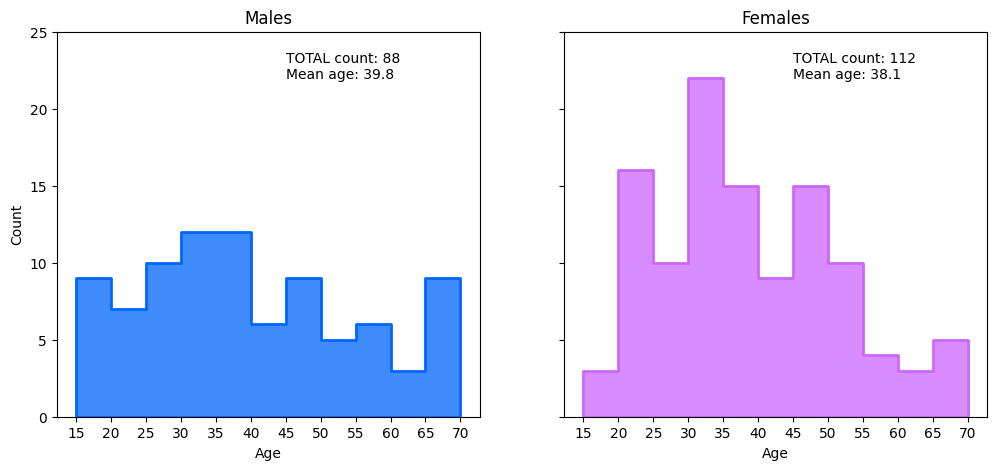

In [10]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.histplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=axes[0], element='step', linewidth=2)
axes[0].set(xticks=age_bins, ylim=(0, 25), title='Males', ylabel='Count')
axes[0].text(45, 23, f"TOTAL count: {males_age.count()}")
axes[0].text(45, 22, f"Mean age: {males_age.mean():.1f}")

sns.histplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=axes[1], element='step', linewidth=2)
axes[1].set(xticks=age_bins, title='Females', ylabel='Count')
axes[1].text(45, 23, f"TOTAL count: {females_age.count()}")
axes[1].text(45, 22, f"Mean age: {females_age.mean():.1f}")

plt.show()


In [11]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


The average age of male customers is lightly higher than female ones (39.8 versus 38.1). Distribution of male age is more uniform than females, where we can observe that the biggest age group is 30-35 years old. Kolgomorov-Smirnov test shows that the differences between these two groups are statistically insignificant.

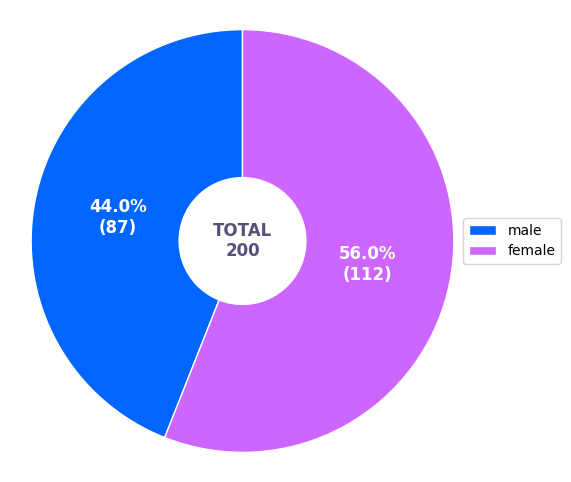

In [12]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

There are slightly more female customers than male ones (112 vs. 87). Females are 56% of total customers.

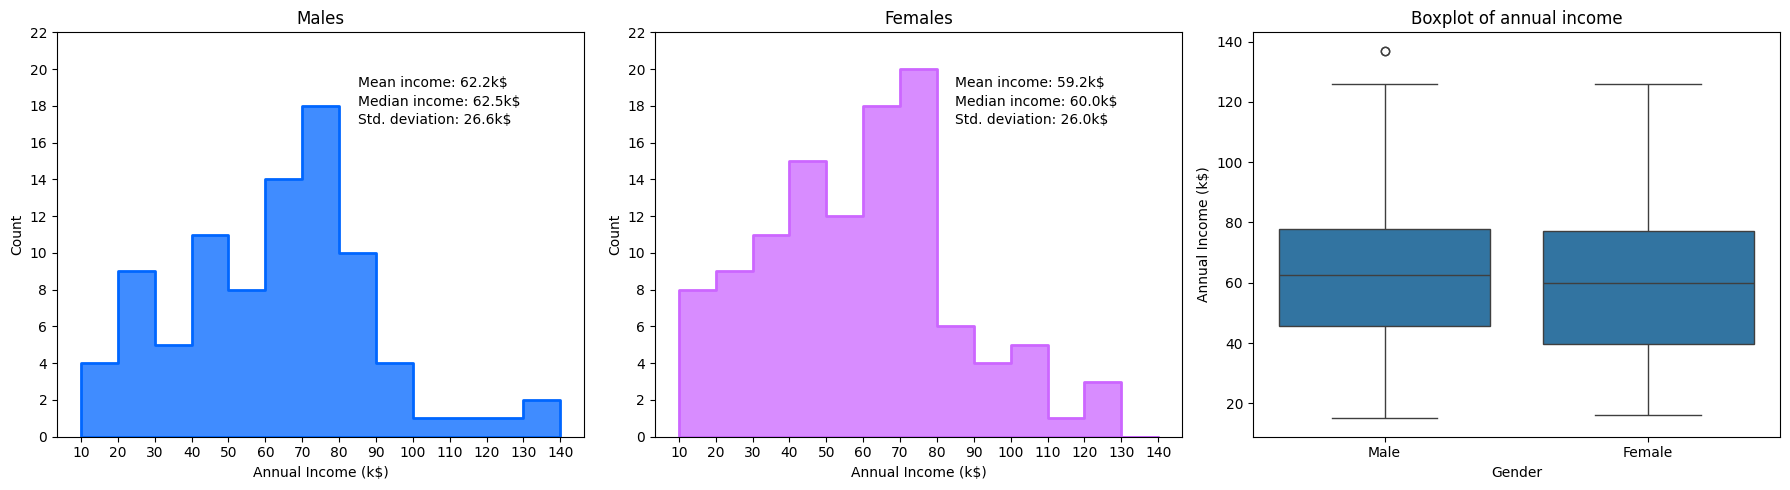

In [13]:
males_income = mall_data[mall_data['Gender'] == 'Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender'] == 'Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10, 150, 10)

# Create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# males histogram
sns.histplot(data=males_income, bins=my_bins, kde=False, color='#0066ff', ax=axes[0], element='step', linewidth=2)
axes[0].set(xticks=my_bins, yticks=range(0, 24, 2), ylim=(0, 22), title='Males', ylabel='Count')
axes[0].text(85, 19, f"Mean income: {males_income.mean():.1f}k$")
axes[0].text(85, 18, f"Median income: {males_income.median():.1f}k$")
axes[0].text(85, 17, f"Std. deviation: {males_income.std():.1f}k$")

# females histogram
sns.histplot(data=females_income, bins=my_bins, kde=False, color='#cc66ff', ax=axes[1], element='step', linewidth=2)
axes[1].set(xticks=my_bins, yticks=range(0, 24, 2), ylim=(0, 22), title='Females', ylabel='Count')
axes[1].text(85, 19, f"Mean income: {females_income.mean():.1f}k$")
axes[1].text(85, 18, f"Median income: {females_income.median():.1f}k$")
axes[1].text(85, 17, f"Std. deviation: {females_income.std():.1f}k$")

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=axes[2])
axes[2].set_title('Boxplot of annual income')

# Adjust spacing between subplots
plt.tight_layout()
plt.show()

In [14]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


Mean income of males is higher than females (62.2 k\\$ vs. 59.2k\\$). Also median income of male customers (62.5k\\$) is higher thn female ones (60k\\$). Standard deviation is similar for both groups. There is one outlier in male group with an annual income of about 140k\\$. K-S test shows that these two groups are not statistically different.

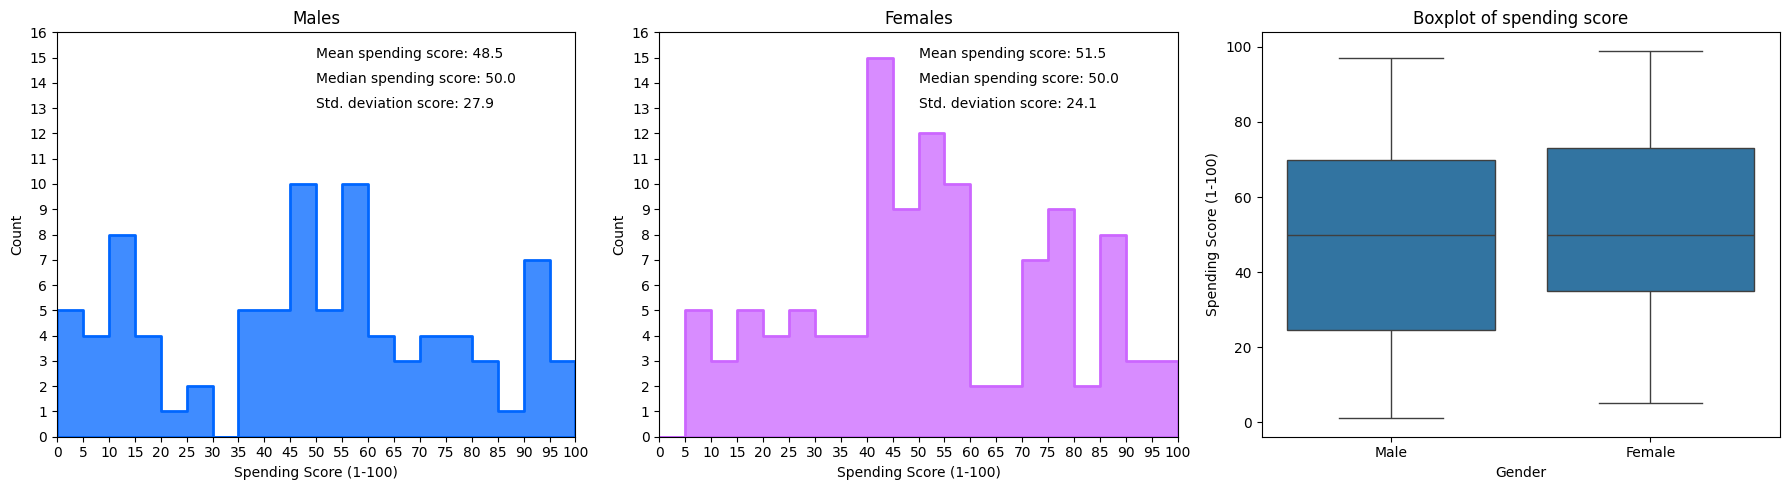

In [15]:
males_spending = mall_data[mall_data['Gender'] == 'Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender'] == 'Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0, 105, 5)

# create a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# males histogram
sns.histplot(data=males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=axes[0], element='step', linewidth=2)
axes[0].set(xticks=spending_bins, xlim=(0, 100), yticks=range(0, 17, 1), ylim=(0, 16), title='Males', ylabel='Count')
axes[0].text(50, 15, f"Mean spending score: {males_spending.mean():.1f}")
axes[0].text(50, 14, f"Median spending score: {males_spending.median():.1f}")
axes[0].text(50, 13, f"Std. deviation score: {males_spending.std():.1f}")

# females histogram
sns.histplot(data=females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=axes[1], element='step', linewidth=2)
axes[1].set(xticks=spending_bins, xlim=(0, 100), yticks=range(0, 17, 1), ylim=(0, 16), title='Females', ylabel='Count')
axes[1].text(50, 15, f"Mean spending score: {females_spending.mean():.1f}")
axes[1].text(50, 14, f"Median spending score: {females_spending.median():.1f}")
axes[1].text(50, 13, f"Std. deviation score: {females_spending.std():.1f}")

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=axes[2])
axes[2].set_title('Boxplot of spending score')

# adjust spacing between subplots
plt.tight_layout()
plt.show()

In [16]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


A mean spending score for women (51.5) is higher than men (48.5). The K-S test p-value indicates that there is no evidence to reject the null-hypothesis, however the evidence is not so strong as in previous comparisons.
Next I will calculate median income for  all age groups.

In [17]:
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

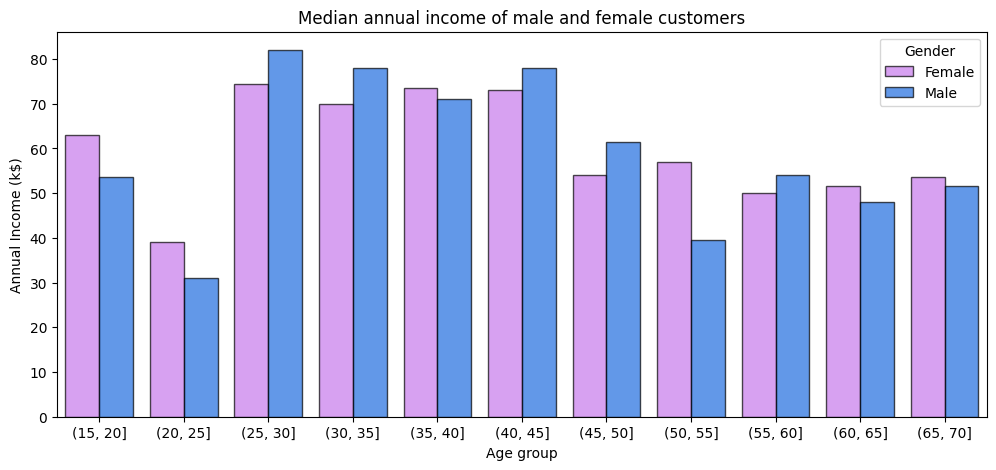

In [18]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

A bar chart above shows that the most wealthy customers are in age of 25-45 years old. The biggest difference between women and men is visible in  age groups 25-30 (male more rich) and 50-55 (female more rich).

<a id='Correlations'></a>
### 3.2 Correlations<a href='#Top' style="text-decoration: none;">^</a><br>
This chapter investigates correlations between numerical variables.

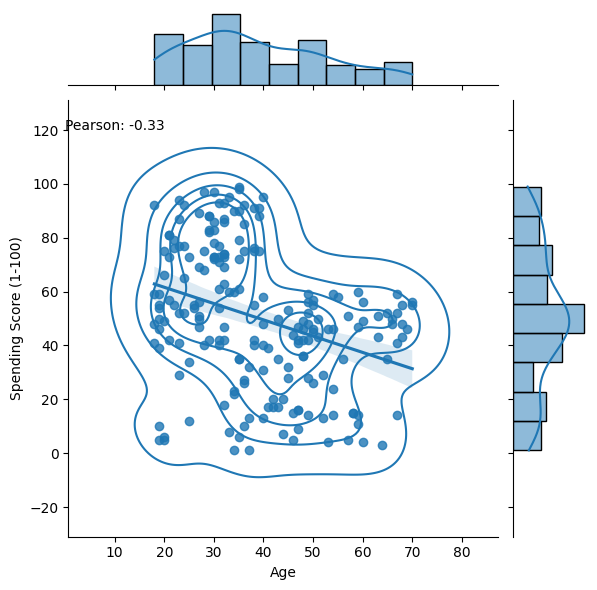

In [19]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot(x='Age', y='Spending Score (1-100)', data=mall_data,
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)


plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

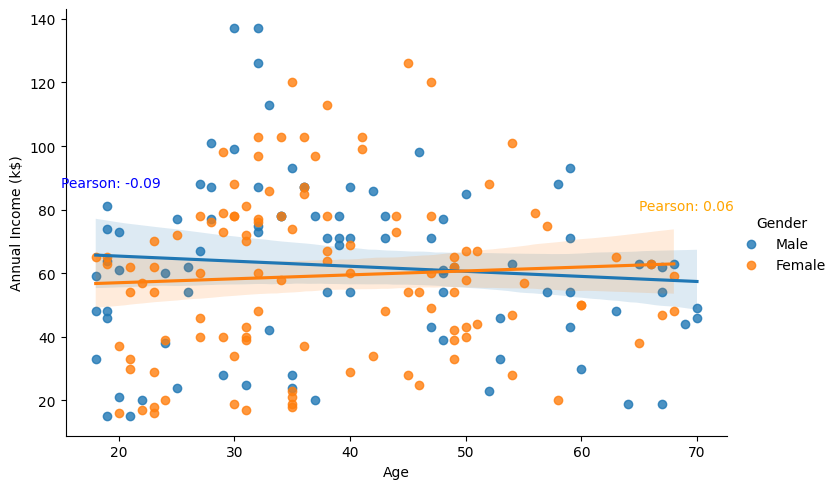

In [20]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot(x='Age', y='Annual Income (k$)', data=mall_data, hue='Gender', aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

There is a negligible correlation between age and annual income of customers for both sex groups.

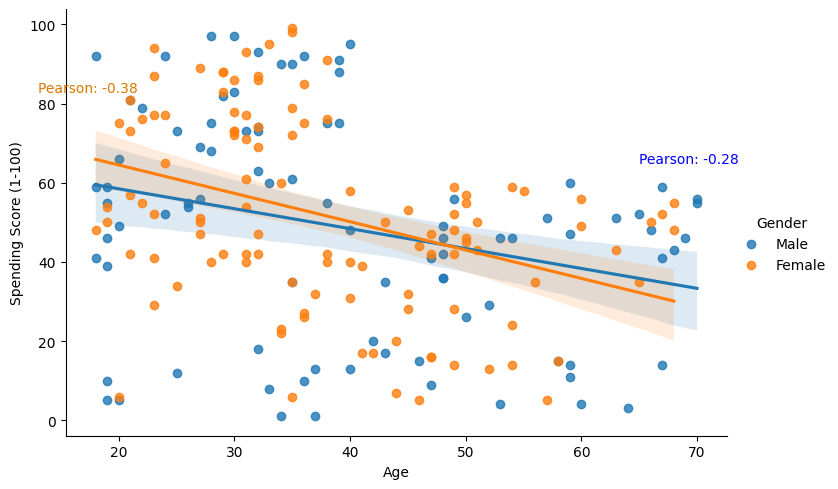

In [21]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot(x='Age', y='Spending Score (1-100)', data=mall_data, hue='Gender', aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

There are week negative correlations (<0.5) between age and spending score for both sex groups.

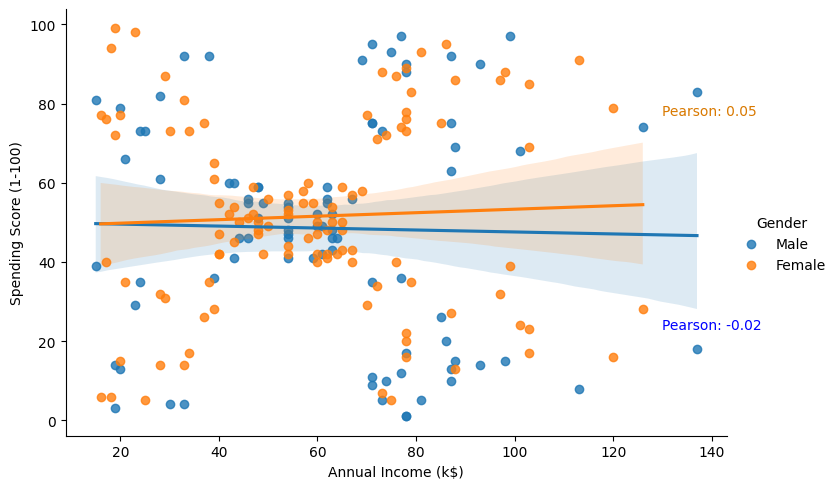

In [22]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=mall_data, hue='Gender', aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

There is a negligible correlation between annual income and spending score of customers for both sex groups.

<a id='Clustering'></a>
## 4. Clustering<a href='#Top' style="text-decoration: none;">^</a><br>  

This section of the notebook describes and demonstrates how to use three clustering algorithms:  
* K-Means
* Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
* Affinity Propagation.

I will not standarize data for this case. When you should or should do it is nicely explained [here on Data Science Stack Exchange](https://datascience.stackexchange.com/questions/6715/is-it-necessary-to-standardize-your-data-before-clustering).

<a id='K-Means'></a>
### 4.1 K-Means<a href='#Top' style="text-decoration: none;">^</a><br>  

This chapter focuses on a very popular K-Means algorithm being taught in most machine learning courses. The chapter contains two sub-chapters: description of the algorithm and a use case (mall customers segmentation).

<a id='K-Means_description'></a>
### 4.1.1 Description<a href='#Top' style="text-decoration: none;">^</a><br>  

The most well-known partitional clustering algorithm is K-Means. It was independently developed in many places in the 50s and 60s and gained great popularity because of its ease of implementation, simplicity and many empirical successes (e.g. in business, medicine and science).  

There are 3 main steps in K-Means algorithm (known also as Lloyd’s algorithm):
<ol>
    <li>Split samples into initial groups by using seed points. The nearest samples to these seed point will create initial clusters.</li>
    <li>Calculate samples distances to groups’ central points (centroids) and assign the nearest samples to their cluster.</li>
    <li>The third step is to calculate newly created (updated) cluster centroids.</li>
</ol>
Then repeat steps 2 and 3 until the algorithm converges.<br>  

As mentioned earlier the goal of K-Means is to minimise the objective function (inertia) over all clusters. The objective function is defined as:

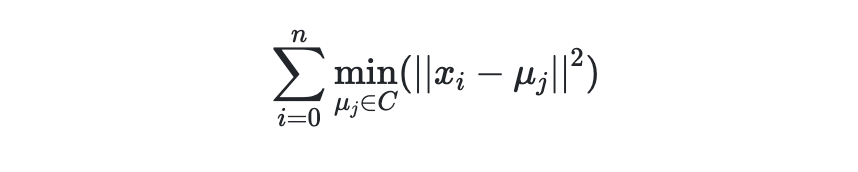

In [63]:
from PIL import Image
import requests
url = 'https://i.stack.imgur.com/OqnnS.png'
im = Image.open(requests.get(url, stream=True).raw)
im

This is known as NP-hard problem, meaning this is a greedy algorithm and converges to the local minimum. The computational cost of Lloyd’s K-Means algorithm is O(kn), where k is a number of clusters and n is a number of samples. This is not bad when compared with other clustering algorithms. Despite converging usually to a local minimum, K-means is relatively fast and when groups are well isolated from each other it is likely that it converges to the global minimum. Because the result of clusterisation depends on the initialisation criteria it is common to run the analysis for various initialisation points and choose the one with minimum resultant inertia. There are some improvements to the algorithm solving problem of the local minima. One, exemplary, improvement is to use enhanced Firefly Algorithms about which you can read [here](https://www.sciencedirect.com/science/article/pii/S1568494619305447).<br><br>

In general, a user of the K-Means algorithm is required to define three main parameters:<br>  

1. **Initialisation criteria**  
    In scikit-learn, a clever initialisation scheme is implemented: “k-means++” proposed by Arthur and Vassilvitskii. It creates initial centroids generally distant from each other increasing probability of obtaining better results. There is also a possibility to use a random point’s generator. There are ongoing efforts to create the most efficient seeding method for K-Means algorithm, one of them is based on Independent Component Analysis and you can read more about it [here](http://www.ymd.nii.ac.jp/lab/publication/conference/2010/IWI-Onoda-2010.pdf).

2. **Number of clusters**  
    Selecting a number of clusters is the most challenging part of setting this algorithm. There are no hard mathematical criteria for this and many heuristic/simplified approaches have been developed. One of the simplest and the most popular one is the elbow method shown in this analysis. Additionaly a silhouette score will be used as well.
    There are also other, often advanced, options for choosing the optimal number of clusters (however, not used in this notebook and not implemented in sklearn), e.g.:
    

* Minimum Message Length (MML) - [more](https://en.wikipedia.org/wiki/Minimum_message_length)
* Minimum Description Length (MDL) - [more](https://en.wikipedia.org/wiki/Minimum_description_length)
* Bayes Information Criterion (BIC) - [more](https://en.wikipedia.org/wiki/Bayesian_information_criterion)
* Akaike Information Criterion (AIC) - [more](https://en.wikipedia.org/wiki/Akaike_information_criterion)
* Dirichlet Process
* Gap statistics


3. **A distance metric (not required in scikit learn implementation)**  
    There are various options to calculate the distance between points. The most popular one is simply the Euclidean metric and it is the one implemented in scikit-learn. It is often called spherical k-means model. It has a drawback that it finds spherical-like groups only and tends to become inflated in highly multi-dimensional analyses (“curse of dimensionality”). There are other options but not implemented in scikit-learn, e.g.:
    
    
* Mahalonobis distance (high computiational cost)
* Itakura-Saito distance
* L1 distance
* Cosine distance
* Bregman distance


There are numerous ongoing researches and variations proposed to K-Means, e.g.:  
* K-Medoid where the centroid is defined as the most centrally located object)
* K-Median where the centroid is calculated using median instead of a mean,
* Fuzzy C-means model

Some take-aways about K-Means:

1. Euclidean distances are used
2. Number of clusters has to be defined for the algorithm
3. Centroid is calculated using mean distance to cluster members
4. Clusters are assumed isotropic and convex
5. Stochastic algorithm – results depend on the initialisation criteria
6. Creates groups of equal variance (minimises inertia)
7. Prone to the “curse of dimensionality”
8. Can be run in parallel – so it scales well

<a id='K-Means_use_case'></a>
### 4.1.2 Use case - customers segmentation<a href='#Top' style="text-decoration: none;">^</a><br>  

The very first step in a clustering analysis is importing K-Means from the sklearn library.

In [24]:
from sklearn.cluster import KMeans

For clustering only numeric columns are used. As mentioned at the beginning the binary variable `gender` will not be used here.

In [25]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

In order to find an appropriate number of clusters, the elbow method will be used. In this method for this case, the inertia for a number of clusters between 2 and 10 will be calculated. The rule is to choose the number of clusters where you see a kink or "an elbow" in the graph.

In [27]:
import warnings
warnings.filterwarnings('ignore')

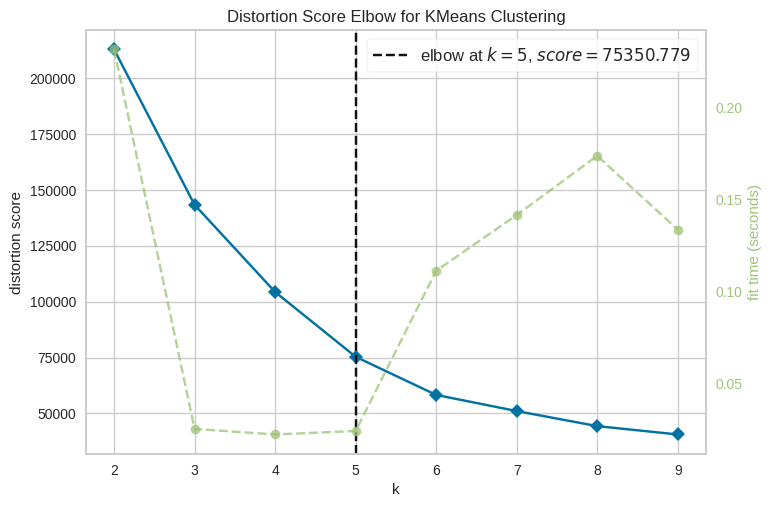

In [28]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

The graph above shows the reduction of a distortion score as the number of clusters increases. However, there is no clear "elbow" visible. The underlying algorithm suggests 5 clusters. A choice of 5 or 6 clusters seems to be fair.

Another way to choose the best number of clusters is to plot the silhuette score in a function of number of clusters. Let's see the results.

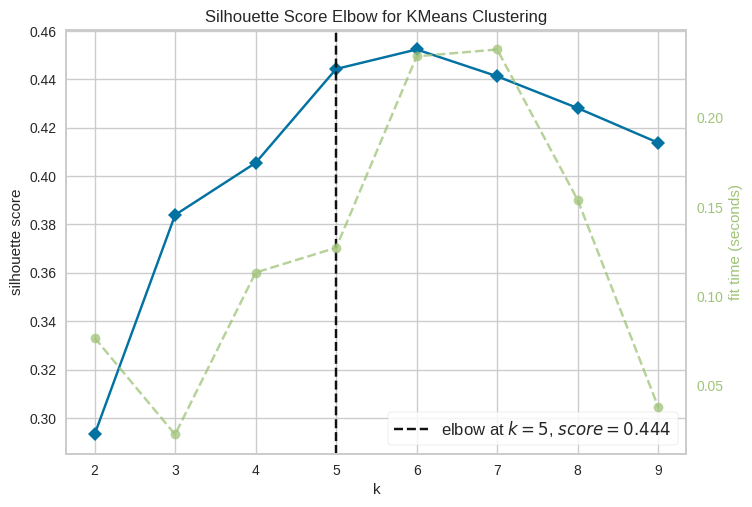

In [29]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')

visualizer.fit(X_numerics)
visualizer.show()
plt.show()

Silhouette score method indicates the best options would be 5 or 6 clusters. Let's compare both.

<u>**5 CLUSTERS**</u>

In [31]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

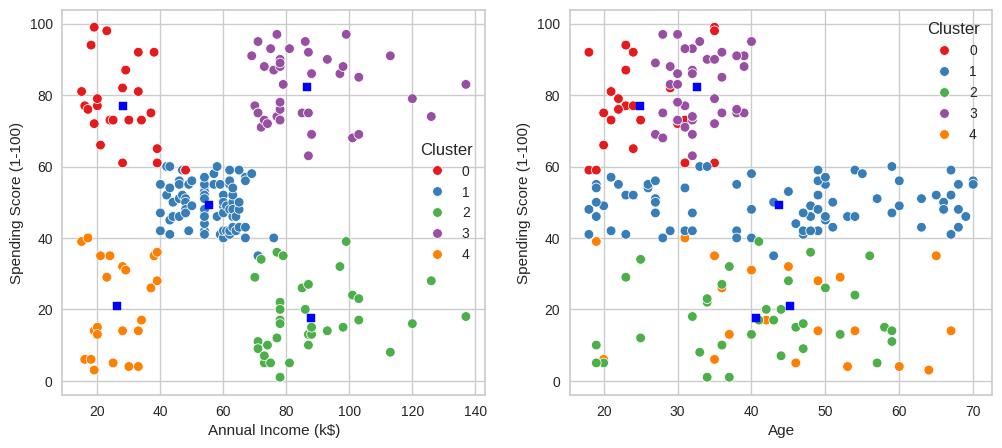

In [32]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))

scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM5_clustered,
                         hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')


axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

K-Means algorithm generated the following 5 clusters:
* clients with **low** annual income and **high** spending score
* clients with **medium** annual income and **medium** spending score
* clients with **high** annual income and **low** spending score
* clients with **high** annual income and **high** spending score
* clients with **low** annual income and **low** spending score

There are no distinct groups is terms of customers age.

Sizes of the clusters:

In [33]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,25
1,77
2,36
3,39
4,23


The biggest cluster is a cluster number 1 with 79 observations ("medium-medium" clients). There are two the smallest ones each containing 23 observations (cluster 3 "high-high" and cluster 0 "low-high" clients). Below there is a 3D projection of 5 generated clusters. It is not very helpful in terms of a visualisation in a static mode but if you run the code in an interactive environment (e.g. Spyder) you can rotate it!

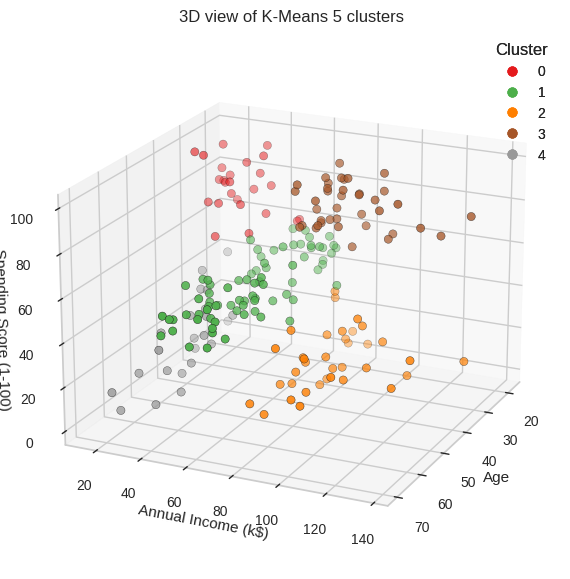

In [34]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d', elev=20, azim=210)
scatter = ax.scatter(KM5_clustered['Age'],
KM5_clustered['Annual Income (k$)'],
KM5_clustered['Spending Score (1-100)'],
c=KM5_clustered['Cluster'],
s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.azim = 25

# Create a legend with the unique colors from the scatter
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Cluster")
ax.add_artist(legend)

plt.show()

Below a Plotly version:

In [35]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

To check the quality of each cluster we can examine the Silhuette plot.

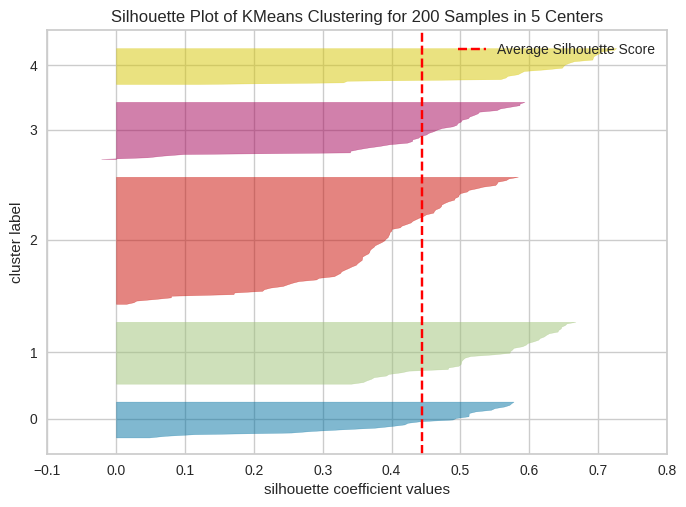

In [36]:
from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(n_clusters=5, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

<u>**6 CLUSTERS**</u>

In [37]:
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points

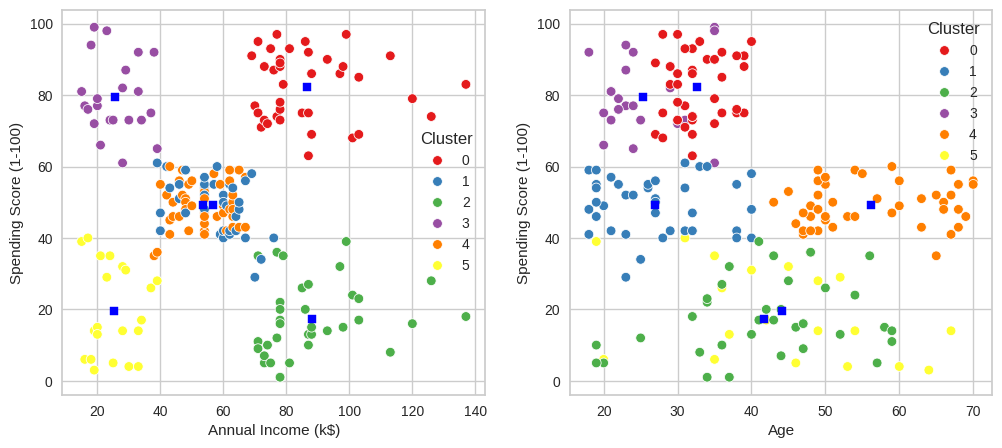

In [38]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')


# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

K-Means algorithm generated the following 6 clusters:
<ol start="0">
    <li>younger clients with **medium** annual and **medium** spending score</li>
    <li>clients with **high** annual income and **low** spending score</li>
    <li>younger clients with **medium** annual and **medium** spending score</li>
    <li>clients with **high** annual income and **high** spending score</li>
    <li>clients with **low** annual income and **low** spending score</li>
    <li>clients with **low** annual income and **high** spending score</li>
</ol>

There are no distinct groups is terms of customers age.

In [39]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,39
1,38
2,35
3,22
4,45
5,21


In [40]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

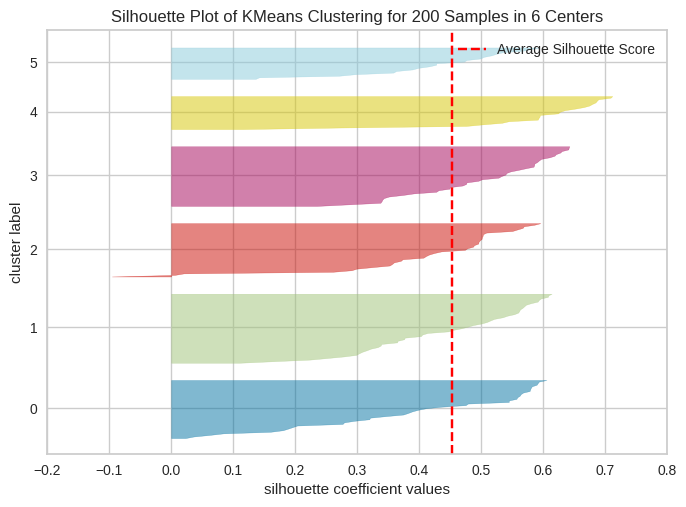

In [41]:
model = KMeans(n_clusters=6, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_numerics)
visualizer.show()
plt.show()

<a id='DBSCAN'></a>
### 4.2 DBSCAN<a href='#Top' style="text-decoration: none;">^</a><br>  

This chapter describes how DBSCAN (Density-Based Spatial Clustering of Applications with Noise) works and shows its implementation to the mall customers segmentation.

<a id='DBSCAN description'></a>
### 4.2.1 Description<a href='#Top' style="text-decoration: none;">^</a><br>  
DBSCAN stands for Density-Based Spatial Clustering of Applications with Noise and is one of clustering algorithms implemented in scikit-learn library. It was proposed by Martin Ester, Hans-Peter Kriegel, Jörg Sander and Xiaowei Xu in 1996 in their famous article <a href="https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf?source=post_page---------------------------">“A Density-Based Algorithm for Discovering Clusters in Large Spatial Database with Noise”</a>.  

As the name of paper suggests the core idea of DBSCAN is around concept of dense regions. The assumption is that natural clusters are composed of densely located points. This requires definition of “dense region”. To do these two parameters are required for DBSCAN algorithm.  
* Eps, ε  - distance
* MinPts – Minimum number of points within distance Eps  

Optionally the distance metric can be specified by a user, but usually Euclidean distance is implemented (like in scikit learn).  

A “dense region” is therefore created by a minimum number of points within distance between all of them, Eps. Points which are within this distance but not close to minimum number of other points are treated as “border points”. Remaining ones are noise or outliers. This is shown in the picture below (for MinPts=3). Red points (D) are in a “dense region” – each one has minimum of 3 neighbours within distance Eps. Green points (B) are border ones – they have a neighbour within distance Eps but less than 3. Blue point (O) is an outlier – no neighbours within distance Eps.

![DBSCAN.jpg](attachment:DBSCAN.jpg)

Advantages of this approach:
* it finds number of clusters itself, based on eps and MinPts parameters
* It it able to differentiate elongated clusters or clusters surrounded by other clusters in contrary to e.g. K-Means where clusters are always convex.
* It is also able to find points not fitting into any cluster – it detects outliers.  

The biggest drawback of DBSCAN:
* High computational expense of average O(n log(n)) coming from a need to execute a neighbourhood query for each point.
* Poorly identifies clusters with various densities

There are various variations and extensions proposed by machine learning researchers to DBSCAN algorithm. For example:
* W. Jing Ch. Zhao and Ch. Jing proposed <a href="https://www.sciencedirect.com/science/article/pii/S1877050919302273">“An improvement method of DBSCAN algorithm on cloud computing”.</a> to solve problem of scalability.
* H. You, L. Chen, J. Yao and X. Wang proposed <a href="https://www.sciencedirect.com/science/article/pii/S0020025516300561">“A three-way clustering method based on an improved DBSCAN algorithm”</a> to overcome problem of clusters with various densities.


<a id='DBSCAN use case'></a>
### 4.2.2 Use case - customers segmentation<a href='#Top' style="text-decoration: none;">^</a><br>  

The first step - importing DBSCAN from sklearn.

In [42]:
from sklearn.cluster import DBSCAN

In DBSCAN there are two major hyperparameters:
* `eps`
* `min_samples`

It is difficult arbitrarily to say what values will work the best. Therefore, I will first create a matrix of investigated combinations.

In [43]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated

DBSCAN_params = list(product(eps_values, min_samples))

Because DBSCAN creates clusters itself based on those two parameters let's check the number of generated clusters.

In [44]:
from sklearn.metrics import silhouette_score

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

A heatplot below shows how many clusters were generated by the DBSCAN algorithm for the respective parameters combinations.

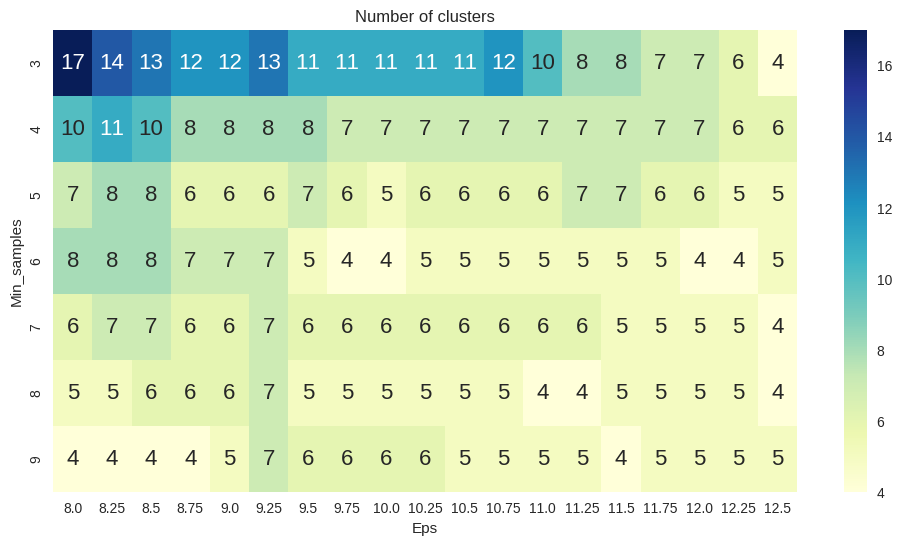

In [45]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

The heatplot above shows, the number of clusters vary from 17 to 4. However, most of the combinations gives 4-7 clusters.
To decide which combination to choose I will use a metric - a silhuette score and I will plot it as a heatmap again.

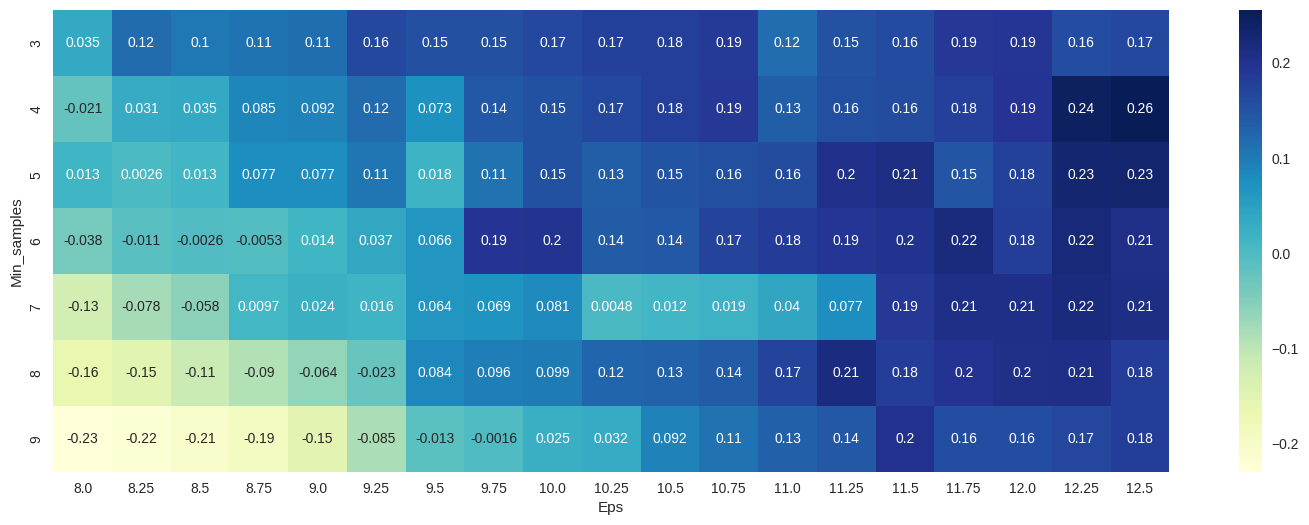

In [46]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Global maximum is 0.26 for `eps`=12.5 and `min_samples`=4.

In [47]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

Checking sizes of clusters.

In [48]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


DBSCAN created 5 clusters plus outliers cluster (-1). Sizes of clusters 0-4 vary significantly - some have only 4 or 8 observations. There are 18 outliers.

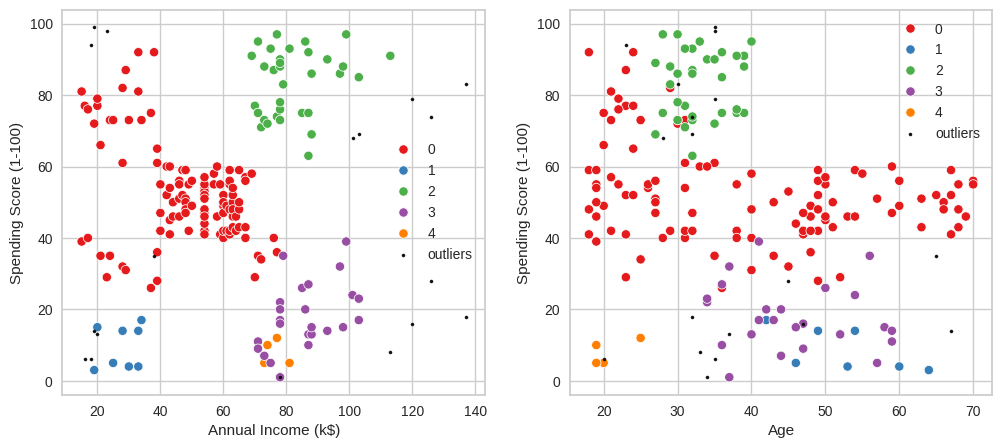

In [49]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot(x='Age', y='Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)


axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

The graph above shows that there are some outliers - these points do not meet distance and minimum samples requirements to be recognised as a cluster.

<a id='AF'></a>
### 4.3 Affinity Propagation<a href='#Top' style="text-decoration: none;">^</a><br>  

This chapter describes how Affinity Propagation works and shows its implementation to the mall customers segmentation.


<a id='AF description'></a>
### 4.3.1 Description<a href='#Top' style="text-decoration: none;">^</a><br>  
Affinity Propagation is a clustering algorithm proposed for the first time by Brendan Frey and Delbert Dueck in 2007 (<a href="https://science.sciencemag.org/content/315/5814/972">"Clustering by Passing Messages Between Data Points"</a>). It is built around the concept of sending messages between a pair of points until it converges. These messages are a way of measuring how similar these two points are to each other and can they be exemplars of each other. The algorithm finds an optimum number of clusters itself. This also implies very high time complexity cost of the order O(n²T) where n is the number of samples and T is the number of iterations until convergence. However, a big advantage of AP is the lack of sensitivity to the initialisation criteria. A very good explanation how this algorithm works is in <a href="https://towardsdatascience.com/unsupervised-machine-learning-affinity-propagation-algorithm-explained-d1fef85f22c8">this article</a> on TowardDataScience.com.  
    
The user is required to specify two parameters:  
* Preference which is a negative number and controls how many exemplars are used
* Damping factor which prevents numerical oscillations when updating messages

Like with any other algorithms there are ongoing efforts to improve it, e.g.:  
* P.Ling and his team proposed and <a href="https://www.sciencedirect.com/science/article/pii/S0167865516303403#bib0001">“Adjustable Preference Affinity Propagation (APAP)”</a> algorithm which can produce better clustering results due to improvement to the element preference calculations
* H. Wenlong and his team proposed <a href="https://www.sciencedirect.com/science/article/pii/S0020025516300561">“Transfer affinity propagation-based clustering”</a> which out-performs current algorithm in a case of a very small dataset.

<a id='AF use case'></a>
### 4.3.2 Use case - customers segmentation<a href='#Top' style="text-decoration: none;">^</a><br>

In [50]:
from sklearn.cluster import AffinityPropagation

In [51]:
no_of_clusters = []
preferences = range(-20000,-5000,100) # arbitraty chosen range
af_sil_score = [] # silouette scores

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    no_of_clusters.append((len(np.unique(AF.labels_))))
    af_sil_score.append(silhouette_score(X_numerics, AF.labels_))

af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() # display only 5 best scores

,preference,clusters,sil_score
82,-11800.0,6.0,0.451649
27,-17300.0,6.0,0.451491
51,-14900.0,6.0,0.451491
52,-14800.0,6.0,0.451440
28,-17200.0,6.0,0.451440


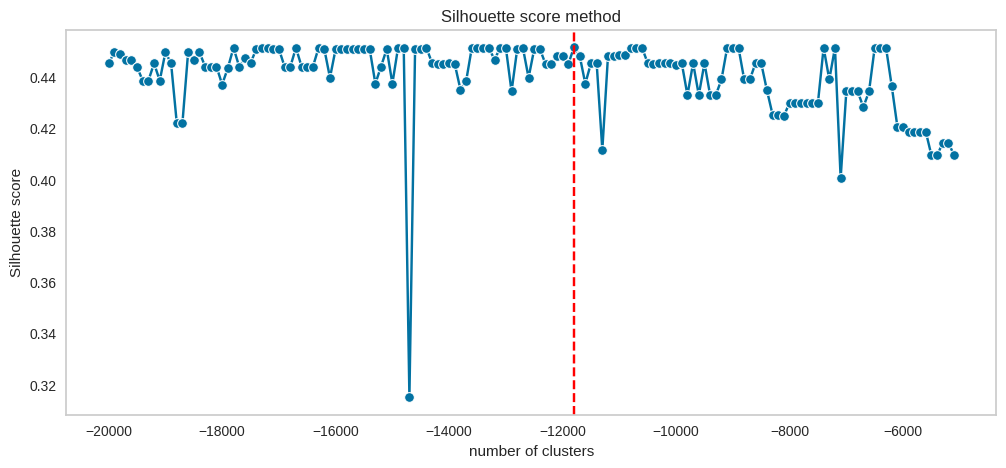

In [52]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(x=preferences, y=af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [53]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [54]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [55]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


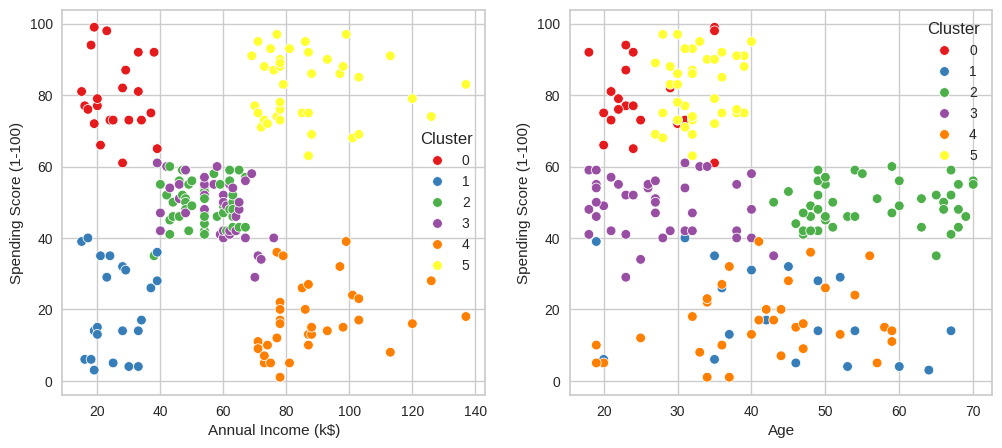

In [56]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))

scat_1 = sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=AF_clustered,
                         hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot(x='Age', y='Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

Clusters generated by the Affinity Propagation algorithm created relatively even-sized clusters similar to ones created by K-Means.

<a id='Comparison and discussion'></a>
## 5. Comparison and discussion <a href='#Top' style="text-decoration: none;">^</a><br>

In this chapter clusters genereated by 3 investigated algorithms will be compared and discussed.

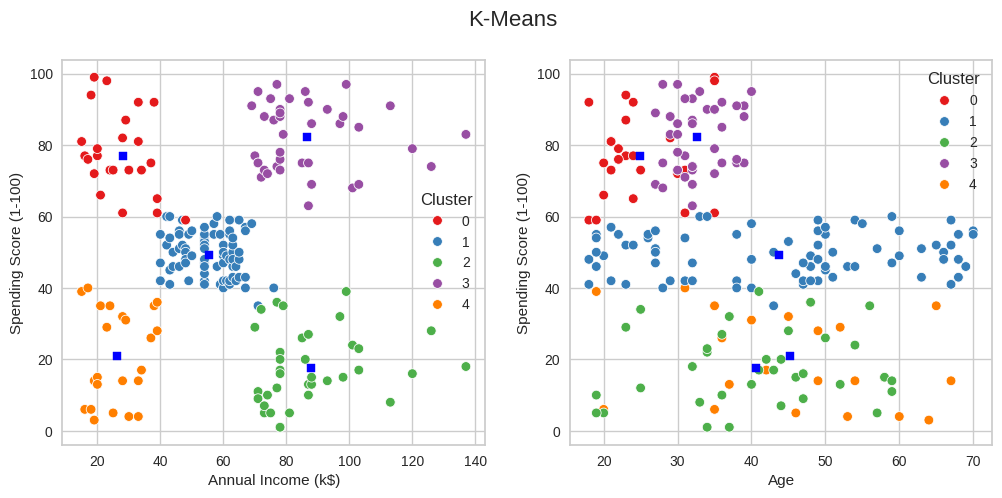

In [57]:
fig1.suptitle('K-Means', fontsize=16)
fig1

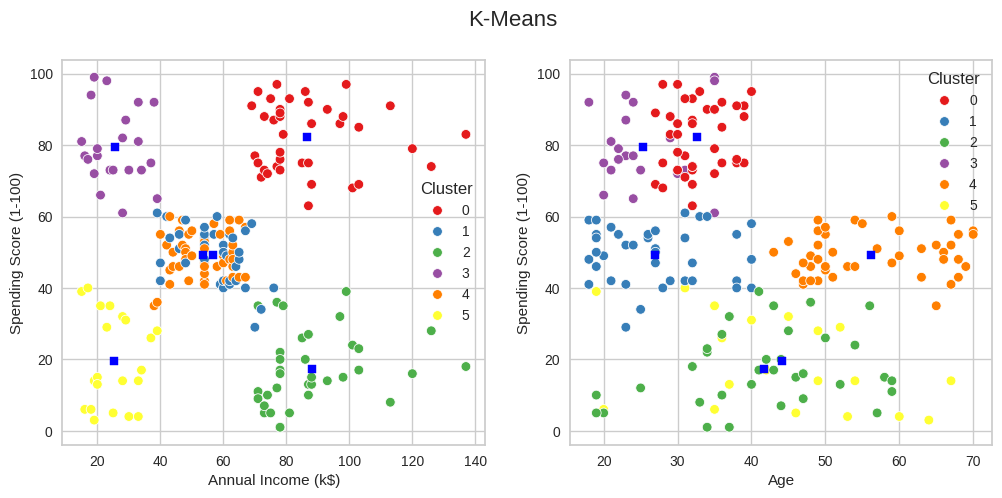

In [58]:
fig11.suptitle('K-Means', fontsize=16)
fig11

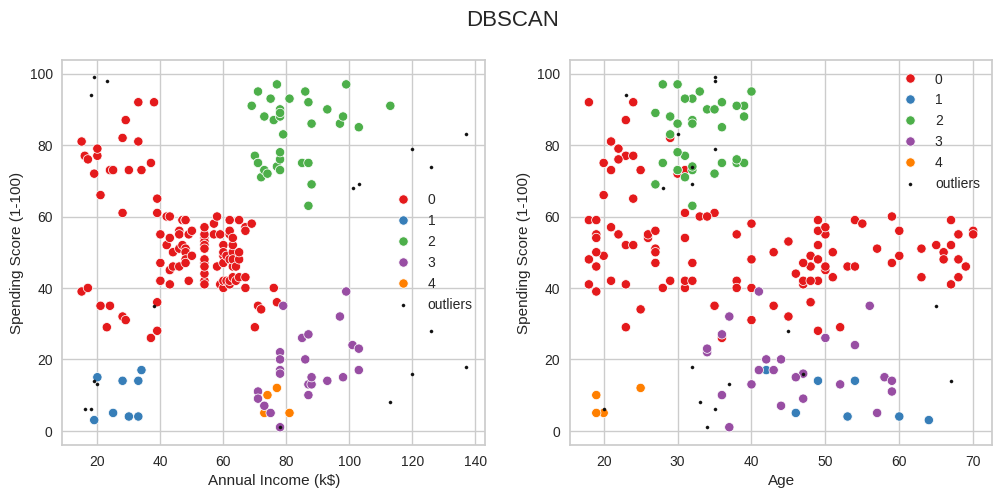

In [59]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

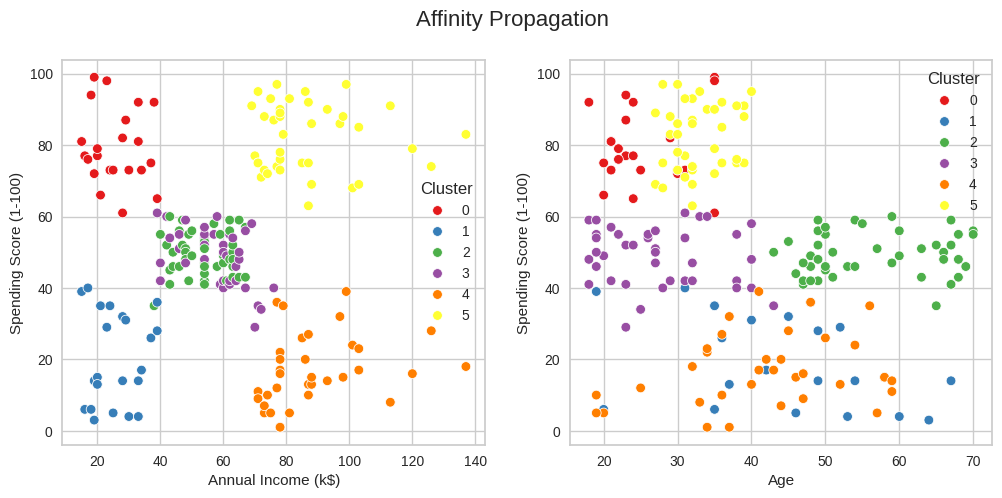

In [60]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

A table below shows sizes of created clusters. Please note that numbering of clusters is different in each method, e.g. cluster no.0 in K-Means is equivalent of cluster no.2 in DBSCAN and no.2 in Affinity Propagation.

In [61]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
0,39.0,112.0,22.0
1,38.0,8.0,22.0
2,35.0,34.0,44.0
3,22.0,24.0,39.0
4,45.0,4.0,34.0
5,21.0,NaN,39.0
-1,NaN,18.0,NaN


From the above comparisons, it is clear that DBSCAN failed to generate reasonable clusters. It is most likely because DBCSAN tries to find clusters based on the density of points. If one of our clusters is less dense than others DBSCAN will produce suboptimal results by not recognising the least dense group as a cluster.

In turn, K-Means and Affinity Propagation algorithms created reasonable 6 clusters.

<a id='References'></a>
## References <a href='#Top' style="text-decoration: none;">^</a><br>


[1] 	H. Yu, L. Chen and X. Wang, "A three-way clustering method based on an improved DBSCAN algorithm," Physica A: Statistical Mechanics and its Applications, vol. 535, 2019.<br>
[2] 	W. Jing, C. Zhao and C. Jiang, "An improvement method of DBSCAN algorithm on cloud computing," Procedia Computer Science, vol. 147, pp. 596-604, 2019. <br>
[3] 	M. Ester, H.-P. Kriegel, J. Sander and X. Xu, "A Density-Based Algorithm for Discovering Clusters in Large Spatial Databases with Noise," KDD-96 Proceedings, pp. 226-231, 1996. <br>
[4] 	D. Arthur and S. Vassilvitskii, "k-means++: The Advantages of Careful Seeding," Proceedings of the eighteenth annual ACM-SIAM symposium on Discrete algorithms, 2007. <br>
[5] 	B. Frey and D. Dueck, "Clustering by Passing Messages Between Data Points," Science, vol. 315, no. 5814, pp. 972-976, 2007. <br>
[6] 	P. Li, H. Ji, B. Wang, Z. Huang and H. Li, "Adjustable preference affinity propagation clustering," Pattern Recognition Letters, vol. 85, pp. 72-78, 2017. <br>
[7] 	H. Wenlong , F.-l. Chung and S. Wang, "Transfer affinity propagation-based clustering," Information Sciences, vol. 348, pp. 337-356, 2016.